3 (3384, 6016)
torch.Size([1, 3, 600, 600])
1 torch.Size([1, 576, 576])
1 (576, 576)
(576, 576)
(576, 576)
torch.Size([1, 6016, 3384])


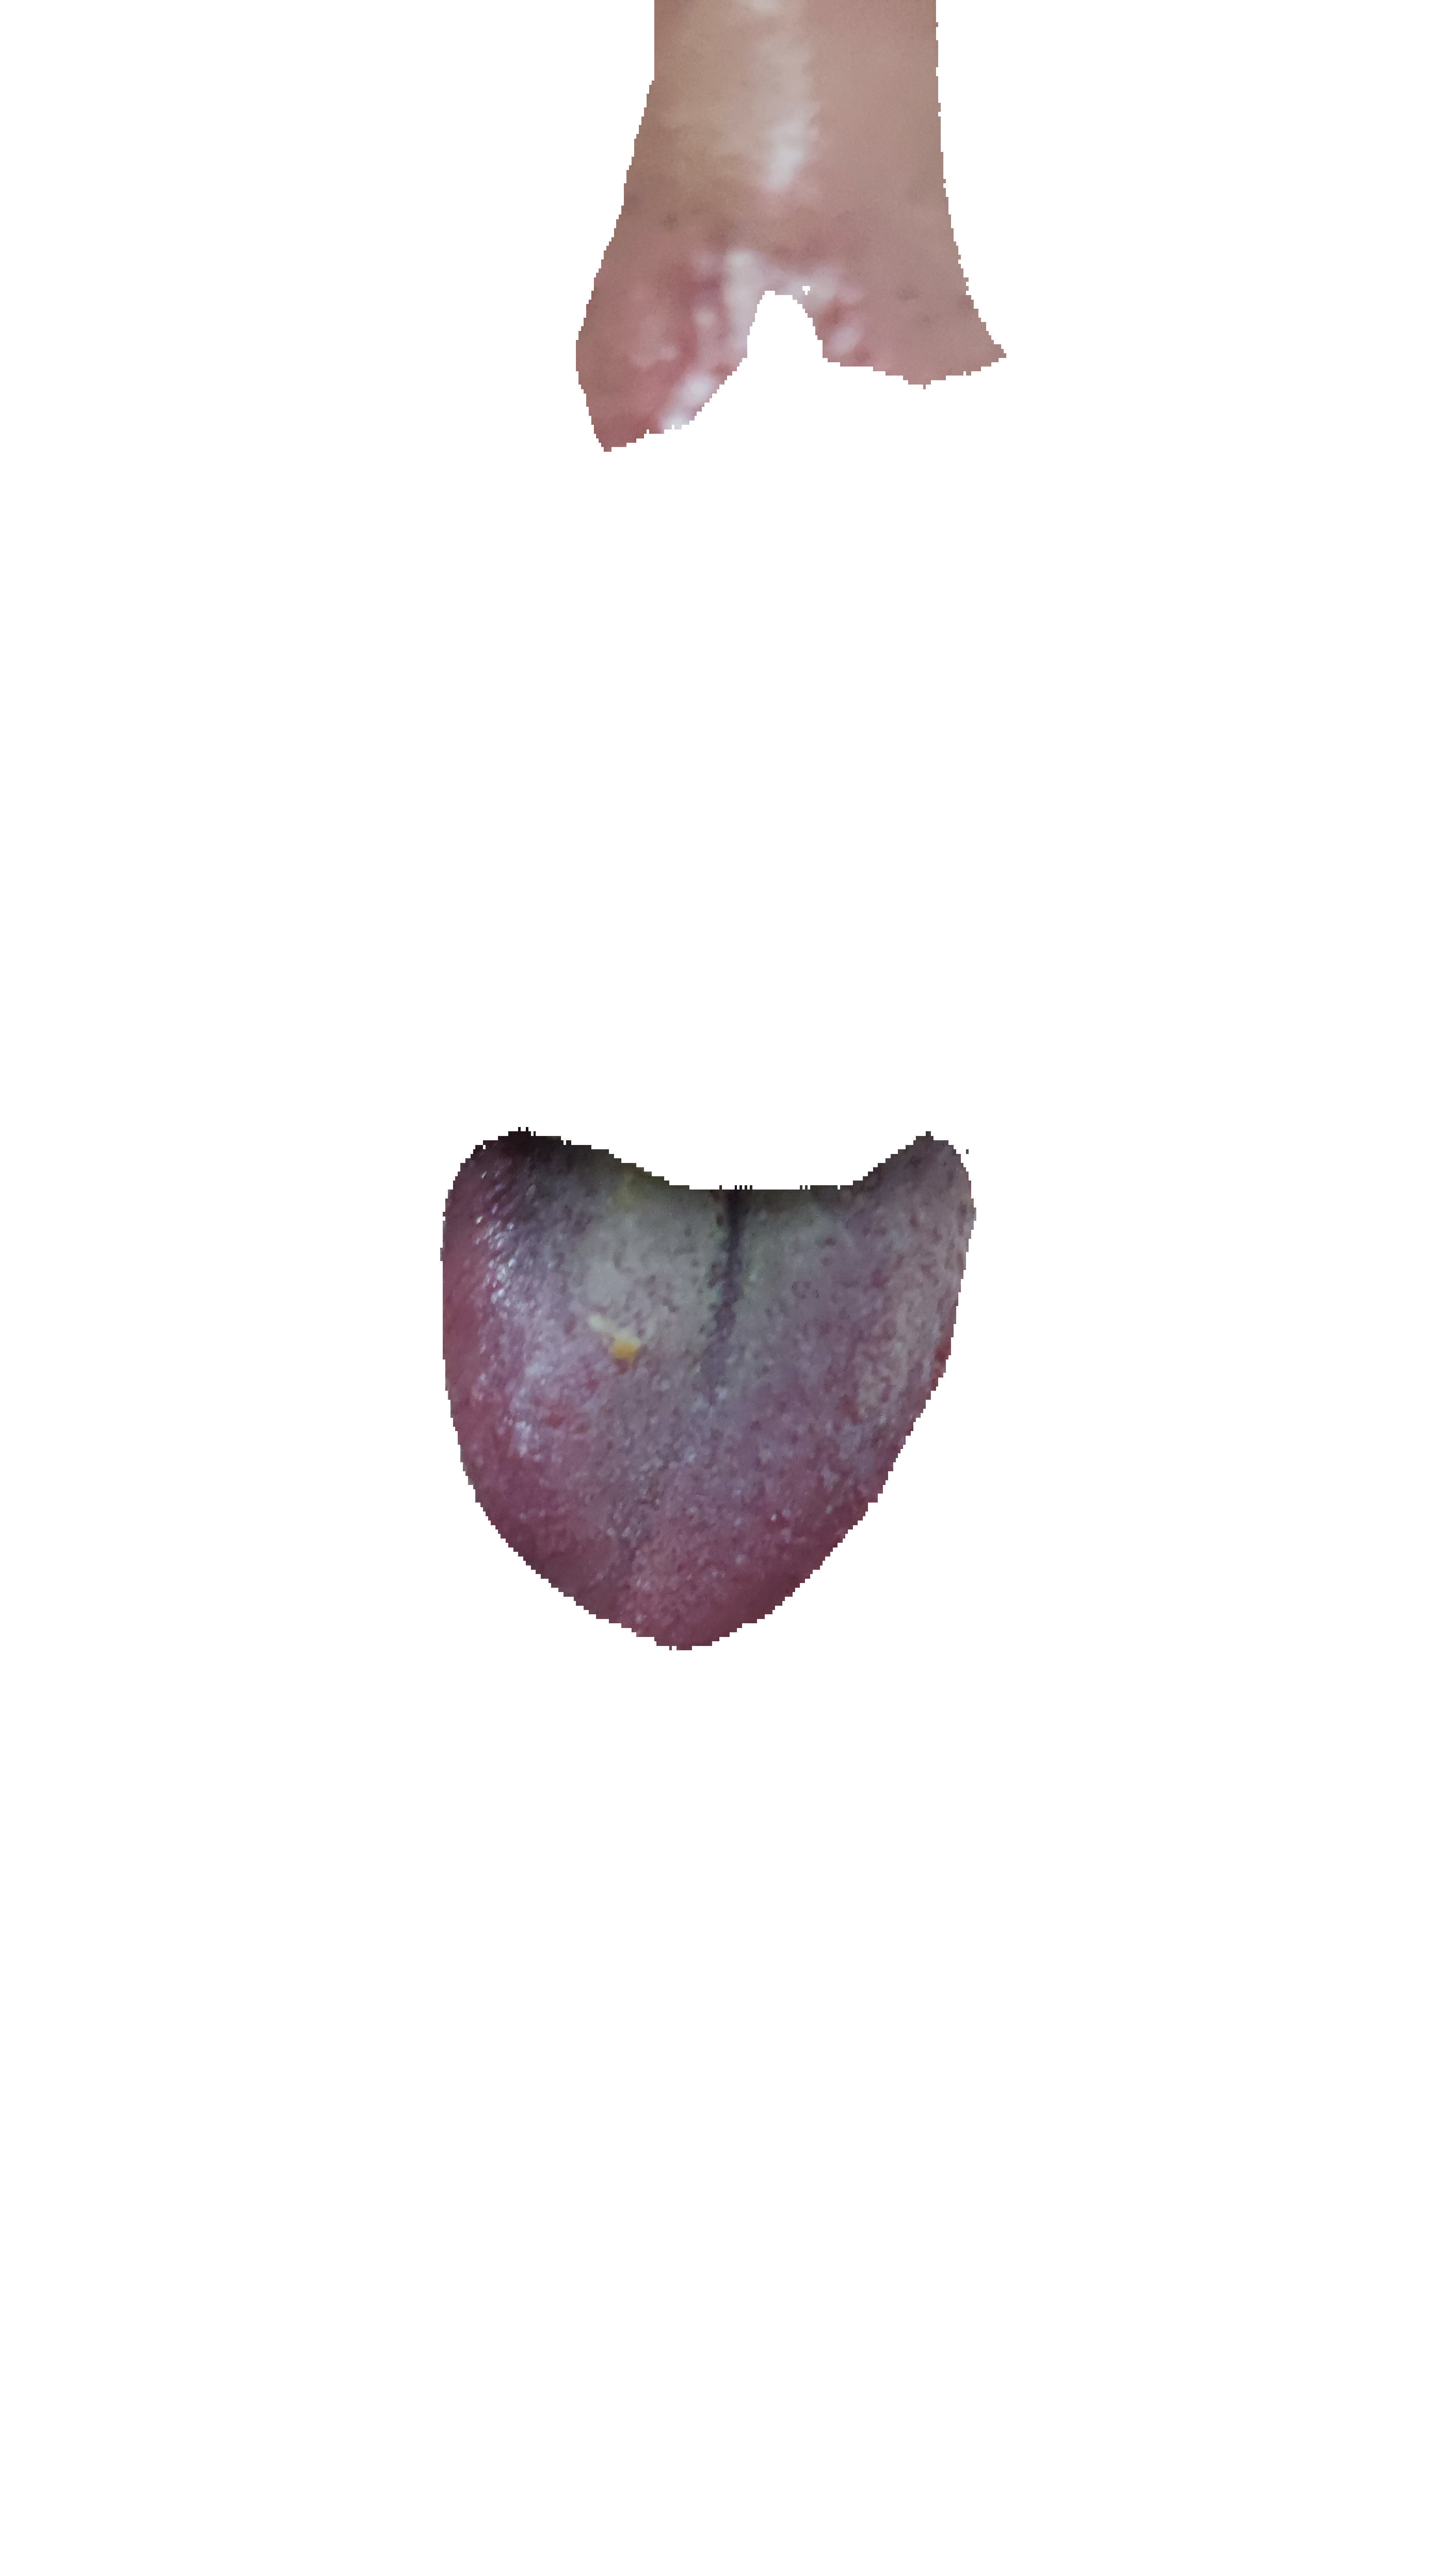

In [3]:
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
from PIL import Image
from torchvision import transforms


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 定义基于VGG16的FCN网络
class VGG16_FCN(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_FCN, self).__init__()
        # 加载预训练的VGG16模型
        vgg16 = models.vgg16(
            weights=models.VGG16_Weights.DEFAULT)

        # 取出VGG16的前面部分（去掉全连接层）
        self.features = vgg16.features

        # 用1x1卷积替换VGG16的全连接层
        self.conv6 = nn.Conv2d(512, 4096, kernel_size=5, padding=2)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout2d()
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout2d()

        # 最后的卷积层用于生成分割结果
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
        self.upscore = nn.ConvTranspose2d(
            num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)

        # 初始化上采样层权重
        self.upscore.weight.data.fill_(0)
        self.upscore.weight.data[:, :, 16, 16] = 1  # 双线性插值

    def forward(self, x):
        # 前向传播
        x = self.features(x)
        x = self.relu6(self.conv6(x))
        x = self.dropout6(x)
        x = self.relu7(self.conv7(x))
        x = self.dropout7(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        return x


def get_segmentation_mask(model, image_path):

    model.eval()

    image = Image.open(image_path).convert('RGB')
    print(3,image.size)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((600, 600)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    print(image.size())
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
    output = torch.sigmoid(output)
    output = torch.argmax(output, dim=1)
    print("1",output.size())
    mask = output.squeeze().cpu().numpy()
    print("1",mask.shape)
    return mask

# Get segmentation mask for a sample image


image_path = './data/test/label_data/test2.jpg'  # Replace with your image path
# image_path = r'data\split_dataset_ultra\images\tongue_front_300137871001_2023-11-06-15-10-33.png_cc645bfb-a335-4dfd-99c2-f71a2e45dfa0.png'
# 载入模型权重
model = VGG16_FCN(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.load_state_dict(torch.load('vgg16_fcn_10_3.pth'))

mask = get_segmentation_mask(model, image_path)
print(mask.shape)


# Create the final mask where tongue region is white and background is black

final_mask = np.zeros_like(mask)
print(mask.shape)

final_mask[mask == 0] = 255

final_mask = Image.fromarray(final_mask.astype(np.uint8))

# 叠加原图
image = Image.open(image_path).convert('RGB')
final_mask = final_mask.resize(image.size, Image.NEAREST)
# 保存 mask
final_mask.save('mask.jpg')
# 读取 mask
final_mask = Image.open('mask.jpg')
# final_mask = final_mask.convert('RGBA')
mask_tensor = transforms.ToTensor()(final_mask)
print(mask_tensor.size())
image.paste(final_mask, (0, 0), final_mask)
image